# Staying up-to date with research literature: An article recommender for research groups

In research the complete knowledge about a topic should be contained in articles published by all researchers. So, it is critical for researchers to know about existing literature in order to compare results and learn from existing ideas. Therefore, it is important to know about recently published articles in the same field. In recent years, the number of publications and journals has increased dramatically. Thus, browsing through recently published articles has become a time-consuming task. In our research group this work was divided between the researchers, so everybody had to monitor a list of journals that publish articles in the domain. For small groups and a still growing journal landscape this task is difficult to maintain. Mendeley, which we used as a literature management database in our group, also tries to recommend new articles, but this function somehow does not work so well. Mostly, I got recommendations for last years' publications of my colleagues. Therefore, I wanted to see if it is possible to start from the existing database of literature that should contain all topics that are interesting for our group and try to build a classifier based on this data.

## Load Mendeley ham

As already mentioned, we used Mendeley to collect publications of interest. The database can be exported by Mendeley in XML format. Unfortunately, some entries had bad encoding and I ran into encoding errors while importing. As I did not find a smarter way, I erased the handful of entries that caused these errors manually.

For the import of the XML database into a pandas dataframe I wrote a function based on code by Austin Taylor (http://www.austintaylor.io/lxml/python/pandas/xml/dataframe/2016/07/08/convert-xml-to-pandas-dataframe/).

In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import xml.etree.ElementTree as ET

class XML2DataFrame:

    def __init__(self, xml_data):
        #self.root = ET.parse(xml_data)
        #parser = ET.XMLParser(encoding='ASCII')
        #parser = ET.XMLParser(recover=True)
        tree = ET.parse(xml_data)
        self.root = tree.getroot()
        
    def parse_root(self, root):
        return [self.parse_element(child) for child in iter(root)]

    def parse_element(self, element, parsed=None):
        if parsed is None:
            parsed = dict()
        for key in element.keys():
            parsed[key] = element.attrib.get(key)
        if element.text:
            parsed[element.tag] = element.text
        for child in list(element):
            self.parse_element(child, parsed)
        return parsed

    def process_data(self):
        structure_data = self.parse_root(self.root)
        return pd.DataFrame(structure_data)
    
def load_mendeley_database(path):
    wanted_loaded = XML2DataFrame(path)
    wanted_df = wanted_loaded.process_data()
    return wanted_df

The imported dataframe contains entries for all articles in the rows with features as columns.

In [3]:
mendeley_path = 'data/NanowireGroup_complete_clear.xml'
ham_df = load_mendeley_database(mendeley_path)
ham_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 26 columns):
abstract                   2793 non-null object
accession-num              1289 non-null object
author                     7047 non-null object
database                   7049 non-null object
edition                    14 non-null object
electronic-resource-num    6314 non-null object
full-title                 6942 non-null object
isbn                       453 non-null object
issue                      6114 non-null object
keyword                    1905 non-null object
label                      735 non-null object
language                   114 non-null object
name                       7049 non-null object
notes                      171 non-null object
pages                      6824 non-null object
path                       7049 non-null object
pub-location               27 non-null object
publisher                  1182 non-null object
ref-type                   7049 non-n

## Select time range and clean data

The database from our group is already maintained over some years and contains publications from over hundred years ago to the beginning of 2018. 

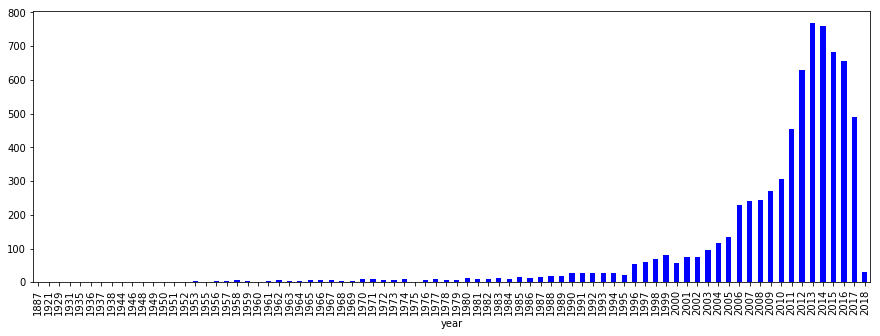

In [4]:
fig, ax = plt.subplots(figsize=(15, 5))
ham_df['year'].groupby(ham_df['year']).count().plot(kind='bar',color='blue',ax=ax)

To make sure that we concentrate on recent nanowire related publications I restricted the publications to be from 2011 to 2018:

In [5]:
min_year = 2010
max_year = 2018
ham_df['year'] = pd.to_numeric(ham_df['year'], errors='coerce')
ham_timerange_df = ham_df[ham_df['year']>min_year]
ham_timerange_df = ham_timerange_df[ham_df['year']<max_year]

/Users/hannokupers/anaconda3/envs/yangon/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


Unfortunately, many entries in the database do not contain abstracts. Also in the Crossref DOI system, that is used later on to retrieve information, the abstracts are often not delivered. That means at this point, there is no straight-forward way to use the abstracts as data. Therefore, I had to use the title information as the feature for later classification.

In [6]:
feature = 'title'
ham_clean_df = ham_timerange_df.dropna(subset=[feature])
ham_clean_df = ham_clean_df[['title', 'electronic-resource-num', 'abstract']]

In the cleaning, the few entries without title information are dropped and all columns except title, DOI number ('electronic-resource-num'), and abstract are kept:

In [7]:
ham_DOI_df = ham_clean_df.dropna(subset=['electronic-resource-num'])
ham_DOI_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4214 entries, 0 to 7035
Data columns (total 3 columns):
title                      4214 non-null object
electronic-resource-num    4214 non-null object
abstract                   1777 non-null object
dtypes: object(3)
memory usage: 131.7+ KB


# Generate spam from DOI request

So far we only have data on interesting articles. For classification we also need some spam data, which is off course not available in the database. Here, I used the DOI identifier of the ham selection to generate spam. This digital document identifier gives a unique index to all digital publications (https://en.wikipedia.org/wiki/Digital_object_identifier). When the DOI of an existing article is incremented, this new DOI should reference another article in the same journal and from a similar topic but must not be included in the ham itself.

In [8]:
import re

def increment_DOI(DOI_original, increment=1):
    DOI_inc = re.sub(r'(\.*.*0*)(\d+)$', lambda x: x.group(1) + str(int(x.group(2)) + increment), DOI_original)
    return DOI_inc

Then a request for the information for this newly generated DOI is done on the Crossref API using the wrapper library from https://github.com/fabiobatalha/crossrefapi. Note that we are only interested in the title of the publication

In [9]:
from crossref.restful import Works

def request_title(DOI):
    works = Works()
    single_work = works.doi(DOI)
    title = single_work['title'][0]
    return title

Now, for every entry in the ham collection multiple requests are done for neighbouring publications. As the DOI number is not always iterating for every journal, this procedure fails in many cases. Here, a smarter system might be necessary to make it more robust. As multiple request are tried, we will still generate enough entries. 
Possibly, some publications are missing in our ham collection - they could have been overlooked or removed in the data cleaning - but when we generate a large collection of spam data (multiple requests per ham entry) these publications should be less severe when the ham data is upsampled later on.

In [ ]:
spam_DOI_title = []
spam_DOI_number = []

for DOI_entry in ham_DOI_df['electronic-resource-num'][:]:
    for inc in range(-5,5):
        spam_DOI = increment_DOI(DOI_entry,inc)
        if ham_DOI_df['electronic-resource-num'].isin([spam_DOI]).any():
            pass
        else:
            try:
                spam_title = request_title(spam_DOI)
                spam_DOI_title.append(spam_title)
                spam_DOI_number.append(spam_DOI)
            except TypeError:
                pass#print('Error')
spam_DOI_df = pd.DataFrame({'electronic-resource-num':spam_DOI_number,'title':spam_DOI_title})

This list of requests takes a very long time as every request is done sequentially. Therefore, I saved the requests after the first attempt to load for later experiments.

In [ ]:
#spam_DOI_df.to_pickle('./spam_DOI_20181025')

In [10]:
spam_DOI_df = pd.read_pickle('data/spam_DOI_20181025')

For consistency we check the frequency of different journals (first part of the DOI number). For journals or publishers where the DOI number does not iterate, our request needs to fail and less entries are generated for the spam collection.

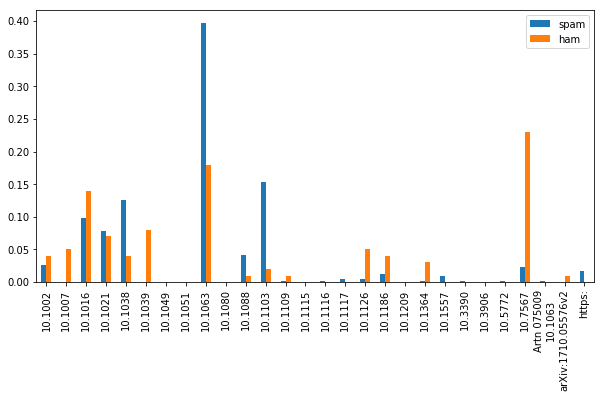

In [11]:
DOI_journal_list = []
for entry in spam_DOI_df['electronic-resource-num']:
    DOI_journal = entry.split('/')[0]
    DOI_journal_list.append(DOI_journal)
    
spam_DOI_df['DOI_journal'] = DOI_journal_list   

DOI_journal_list = []
for entry in ham_DOI_df['electronic-resource-num'][:100]:
    DOI_journal = entry.split('/')[0]
    DOI_journal_list.append(DOI_journal)
    
ham_DOI_slice_df = pd.DataFrame({'DOI_journal':DOI_journal_list})

spam_counts = spam_DOI_df['DOI_journal'].value_counts() / spam_DOI_df['DOI_journal'].count()
ham_counts = ham_DOI_slice_df['DOI_journal'].value_counts() / ham_DOI_slice_df['DOI_journal'].count()

fig, ax = plt.subplots(figsize=(10,5))
pd.concat([spam_counts.rename('spam'),ham_counts.rename('ham')],axis=1,sort=True).plot.bar(ax=ax)

In [12]:
print(spam_DOI_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7571 entries, 0 to 7570
Data columns (total 3 columns):
electronic-resource-num    7571 non-null object
title                      7571 non-null object
DOI_journal                7571 non-null object
dtypes: object(3)
memory usage: 177.5+ KB
None


Not all journals or publishers appear in the spam collection but the journals that appear most often in the ham collection also contribute strongly to the spam collection. To improve this, a better way of incrementing the DOI number might help or using the volume number of the publication and then requesting titles of all other publications in this volume might be smarter.

# Combine spam and ham

To use the collected ham and spam data for classification we add columns for the category (1: ham, 0:spam) and combine the two dataframes.

In [13]:
ham_DOI_df['category'] = 1
spam_DOI_df['category'] = 0

/Users/hannokupers/anaconda3/envs/yangon/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
combined_df = ham_DOI_df.copy().append(spam_DOI_df);
combined_df = combined_df.copy().reset_index(drop=True)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11785 entries, 0 to 11784
Data columns (total 5 columns):
DOI_journal                7571 non-null object
abstract                   1777 non-null object
category                   11785 non-null int64
electronic-resource-num    11785 non-null object
title                      11785 non-null object
dtypes: int64(1), object(4)
memory usage: 460.4+ KB


/Users/hannokupers/anaconda3/envs/yangon/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [15]:
list(spam_DOI_df[feature].head(10))

['Erratum: “Pb0.94La0.04[(Zr0.70Sn0.30)0.90Ti0.10]O3 antiferroelectric bulk ceramics for pulsed capacitors with high energy and power density” [Appl. Phys. Lett. 110, 142904 (2017)]',
 'Klein-Gordon-Schrödinger system: Dinucleon field',
 'Performance evaluation and bias correction of DBS measurements for a 1290-MHz boundary layer profiler',
 'Selective multiple domain wall injection using spin-orbit torque',
 'Using periodic orbits to compute chaotic transport rates between resonance           zones',
 'Optimized neural network based thermal and electrical scheduling of virtual power plant in the presence of energy storage',
 'Piezoelectric energy harvester for low engine vibrations',
 'Analysis of a commercial-scale photovoltaics system performance and economic feasibility',
 'Piezoelectricity of green carp scales',
 'Influence of internal electric and elastic fields on characteristics of heterogeneous ferroelectric materials']

# Train model

## Feature preparation

Before anything is done with the data, the combined collection is split into train and test set to have a valid measure at the end. I used a test size of 30%:

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.array(combined_df[feature]).reshape(-1, 1), combined_df['category'], test_size = 0.3)

The size of the spam collection is not easily controllable and we tried to achieve a large collection. Therefore, the combined collection contains more entries for spam than ham. This imbalance in samples can lead to problems for many machine learning algorithms because the category with higher occurence obtains a higher weight. Therefore, we use oversampling to obtain the same number of samples for both categories. Here, random samples are re-sampled from the ham data and the ham collection increases in size. Only the train set is oversampled as the test set needs to be in its original shape.

Unfortunately, the oversampling did not improve the results significantly but caused some difficulties with the validation of the neural network, therefore I turned it off.

In [17]:
#from imblearn.over_sampling import RandomOverSampler 

#ros = RandomOverSampler()
#X_train, y_train = ros.fit_sample(X_train.reshape(-1, 1), y_train)
#X_test, y_test = ros.fit_sample(X_test.reshape(-1, 1), y_test)

X_train, X_test = X_train.ravel(), X_test.ravel()

In [18]:
_ , counts_train = np.unique(y_train, return_counts=True)
print('Number of samples per category in train: %s' % counts_train)

_ , counts = np.unique(y_test, return_counts=True)
print('Number of samples per category in test: %s' % counts)

Number of samples per category in train: [5278 2971]
Number of samples per category in test: [2293 1243]


## Stemming

In a straight-forward bag-of-words approach, every word is treated as unique. Words that have the same root or so called stem are treated as completely indepent. Obviously, that is not great for words like 'nanowire' and 'nanowires' for example. Therefore, I used an implementation of a Porter Stemmer in gensim to reduce all occuring words first to its stem.

In [19]:
from gensim.parsing.porter import PorterStemmer

p = PorterStemmer()

X_train_pstem = p.stem_documents(X_train)
X_test_pstem = p.stem_documents(X_test)

## Vectorizer

The titles need to be converted to some kind of numerical data. A typical way to convert a text into a vector is the bag-of-words approach. Here, every word in a text gets a unique ID and a dictionary of all words in the text is build. This way, every title is converted into a large vector that has the size of the dictionary, indicating the occurence of every word in the respective title. These resulting matrix of all word vectors from all titles is the very sparse. Typically, some words appear in every text and are not informative on the content on its own, such as 'the', 'a', 'he' in english text. By setting stop_words in the transformer, such words are automatically removed from the dictionary. Also, the words in the title are not independent from each other but the titles structure is important for its meaning. If only the word occurence is counted, this meaning is lost. To avoid this effect slightly, ngrams can be used which are combinations of n neighbouring words into one, such as 'nanowire growth'. Here we chose to use 1, 2, and 3-grams.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

count_vect = TfidfVectorizer(use_idf='False',stop_words='english',min_df=5, ngram_range=(1,3)) #min_df=1, 
X_train_counts = count_vect.fit_transform(X_train_pstem) #'abstract'
X_test_counts = count_vect.transform(X_test_pstem)

In [21]:
print(X_train_counts.shape)
#print(X_train_stem.shape)

(8249, 3622)


## Naive Bayes classifier

Now, let's build a classifier for interesting and not-interesting journal articles. First, we use a Naive Bayes classifier which can be trained in a short time and is often used for text classification cases. Here, 'Naive' means, that all features are assumed to be independent from each other. That is not really the case for text, where the grammatical structure and the following words determine the meaning of a sentence. However, by using higher grams like 2-grams, this disadvantage can be slightly overcome.

To find the best hyperparameters I built a pipeline for the classifier but also the vectorizer. This way even for gram size or minimum word occurence the best parameters can be conveniently deduced.

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

nb_pipeline = Pipeline([
        ('vect', TfidfVectorizer(stop_words='english')),
        ('nbclf', MultinomialNB())    
])

param_grid_nb = [
    {'vect__use_idf': [False, True], 
     'vect__min_df': [2, 5 ,10], 
     'vect__ngram_range': [(1,2),(1,3)],
     'nbclf__alpha': [0.01, 0.05, 0.1]}
]

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_search_nb = GridSearchCV(nb_pipeline, param_grid_nb, cv=10)
grid_search_nb.fit(X_train_pstem, y_train)

These are the best parameters which I use to train the model on the entire train set.

In [ ]:
grid_search_nb.best_params_

In [23]:
nb_pipeline.set_params(nbclf__alpha=0.05,vect__min_df=2,vect__ngram_range=(1, 2), vect__use_idf=False).fit(X_train_pstem, y_train)

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
...,
        vocabulary=None)), ('nbclf', MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True))])

Giving an accuracy of:

In [24]:
from sklearn.metrics import accuracy_score

y_pred_nb_pipeline = nb_pipeline.predict(X_test_pstem)
accuracy_score(y_pred_nb_pipeline, y_test)

0.8877262443438914

The confusion matrix shows that there  exists an imbalance between false positive and false negative classifications.

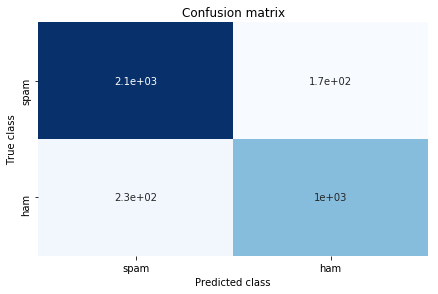

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix = confusion_matrix(y_test, y_pred_nb_pipeline)
dataframe = pd.DataFrame(matrix, index=['spam', 'ham'], columns=['spam', 'ham'])

sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues')
plt.title('Confusion matrix'), plt.tight_layout()
plt.ylabel('True class'), plt.xlabel('Predicted class')
plt.show()

In [27]:
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

nb_ppl_proba = nb_pipeline.predict_proba(X_test_pstem)
fpr_nb_ppl, tpr_nb_ppl, thresholds_nb_ppl = roc_curve(y_test, nb_ppl_proba[:,1], pos_label=1)
auc_nb = roc_auc_score(y_test, nb_ppl_proba[:,1])
prec_nb_ppl, rec_nb_ppl, thresholds_pr_nb_ppl = precision_recall_curve(y_test, nb_ppl_proba[:,1], pos_label=1)

## Random forrest

To investigate if a different classifier may lead to better results we do the same procedure for a Random Forrest classifier.

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
        ('vect', TfidfVectorizer(stop_words='english')),
        ('rfclf', RandomForestClassifier())    
])

param_grid_rf = [
    {'vect__use_idf': [False], 
     'vect__min_df': [5, 10], 
     'vect__ngram_range': [(1,2),(1,3)],
     'rfclf__n_estimators': [200, 500, 1000]}
]

In [ ]:
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=10)

grid_search_rf.fit(X_train_pstem, y_train)

In [ ]:
grid_search_rf.best_params_

Now use the best parameters to train a model on the entire train set.

In [29]:
rf_pipeline.set_params(rfclf__n_estimators=500,vect__min_df=5,vect__ngram_range=(1, 3),vect__use_idf=False).fit(X_train_pstem, y_train)

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [30]:
y_pred_rf_pipeline = rf_pipeline.predict(X_test_pstem)
accuracy_score(y_pred_rf_pipeline, y_test)

0.9007352941176471

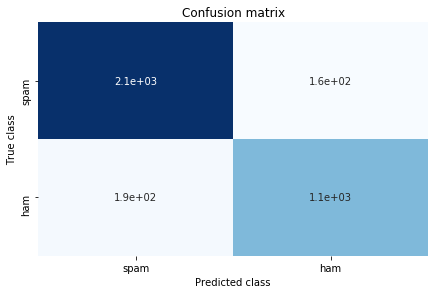

In [31]:
matrix = confusion_matrix(y_test, y_pred_rf_pipeline)
dataframe = pd.DataFrame(matrix, index=['spam', 'ham'], columns=['spam', 'ham'])

sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues')
plt.title('Confusion matrix'), plt.tight_layout()
plt.ylabel('True class'), plt.xlabel('Predicted class')
plt.show()

In [32]:
rf_ppl_proba = rf_pipeline.predict_proba(X_test_pstem)
fpr_rf_ppl, tpr_rf_ppl, thresholds_rf_ppl = roc_curve(y_test, rf_ppl_proba[:,1], pos_label=1)
auc_rf = roc_auc_score(y_test, rf_ppl_proba[:,1])
prec_rf_ppl, rec_rf_ppl, thresholds_pr_rf_ppl = precision_recall_curve(y_test, rf_ppl_proba[:,1], pos_label=1)

## LSTM with embedding

A more advanced model compared to the bag of words approach is to use word embeddings. Here, every word gets a vector in an embedding space which is learned during training. Then, a sentence is a sequence of word vectors, which is modeled in a recurrent neural network using LSTM cells. Thereby, the order of the words is used as additional information.

First, the words in the titles are tokenized, meaning every word gets a distinct integer number and a vocabulary is built.

In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_words = 8000

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train_pstem) 

X_train_seq = tok.texts_to_sequences(X_train_pstem)
X_test_seq = tok.texts_to_sequences(X_test_pstem)

The titles have different length, but the LSTM network has a fixed size of cells. Therefore, all titles are padded to have a fixed length by introducing a free number (10327) to missing places.

(array([  0.,   6.,  36.,  77., 120., 207., 340., 481., 692., 765., 888.,
        794., 786., 686., 585., 519., 363., 262., 185., 138., 109.,  57.,
         51.,  28.,  21.,  17.,  11.,   4.,   9.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 29 Patch objects>)

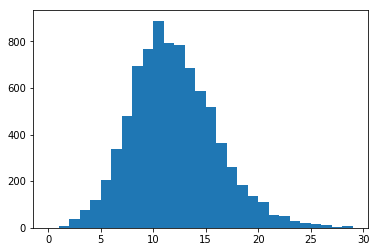

In [34]:
seq_len = [len(seq.split()) for seq in X_train]
plt.hist(seq_len, bins=range(30))

In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
n_features = len(tok.word_index)
max_len = 25

X_train_sequences = pad_sequences(X_train_seq, maxlen=max_len, value=n_features)
X_test_sequences = pad_sequences(X_test_seq, maxlen=max_len, value=n_features)
print(X_train_sequences[4])

[8880 8880 8880 8880 8880 8880 8880 8880   14    3 1682  522  182    1
 1869  134  169 4167  839   30   24  503  351   32  133]


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
 
lstm_model = Sequential()
lstm_model.add(Embedding(n_features + 1, 16, input_length=max_len))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(units=1, activation='sigmoid'))

opt = Adam(lr=0.01, decay=0.01)

lstm_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print(lstm_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 16)            142096    
_________________________________________________________________
lstm (LSTM)                  (None, 50)                13400     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 155,547
Trainable params: 155,547
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
history_lstm = lstm_model.fit(X_train_sequences, y_train, 
          epochs=2, batch_size=32, 
          validation_split=0.1)

/Users/hannokupers/anaconda3/envs/yangon/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/hannokupers/anaconda3/envs/yangon/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7424 samples, validate on 825 samples
Epoch 1/2
7424/7424 [==============================] - 35s 5ms/step - loss: 0.3514 - acc: 0.8521 - val_loss: 0.2676 - val_acc: 0.9018
Epoch 2/2
7424/7424 [==============================] - 30s 4ms/step - loss: 0.1943 - acc: 0.9297 - val_loss: 0.2838 - val_acc: 0.9030


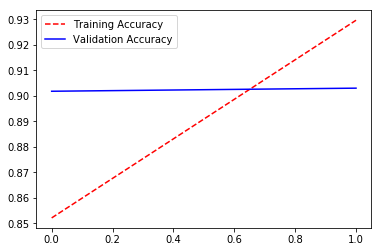

In [38]:
training_acc = history_lstm.history['acc']
test_acc = history_lstm.history['val_acc']
plt.plot(training_acc, 'r--')
plt.plot(test_acc, 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

In [39]:
scores = lstm_model.evaluate(X_test_sequences, y_test)
print("Accuracy:", scores[1]) # 0.896

3536/3536 [==============================] - 3s 851us/step
Accuracy: 0.896210407239819


In [42]:
y_pred_lstm = lstm_model.predict(X_test_sequences).ravel()
fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_test, y_pred_lstm)
auc_lstm = roc_auc_score(y_test, y_pred_lstm)

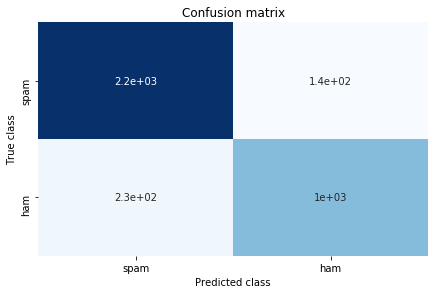

In [43]:
matrix = confusion_matrix(y_test, np.round(y_pred_lstm,0))
dataframe = pd.DataFrame(matrix, index=['spam', 'ham'], columns=['spam', 'ham'])

sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues')
plt.title('Confusion matrix'), plt.tight_layout()
plt.ylabel('True class'), plt.xlabel('Predicted class')
plt.show()

## Evaluation of models

For an evaluation of the two classifiers the ROC curve is helpful, showing the false positive rate and true positive rate for different threshold values. Also precision and recall curves can be compared. Both evaluation methods show that the random forest model results in better results underlining the 88.7% accuracy value. The embedding model with LSTM cannot improve these results, indicating that the accuracy is not limited by the model.

In [44]:
print('Area under curve for Naive Bayes: ', auc_nb,'\nArea under curve Random Forrest: ', auc_rf,'\nArea under curve LSTM: ', auc_lstm)

Area under curve for Naive Bayes:  0.9407662412343839 
Area under curve Random Forrest:  0.9510497337203472 
Area under curve LSTM:  0.9458921991060976


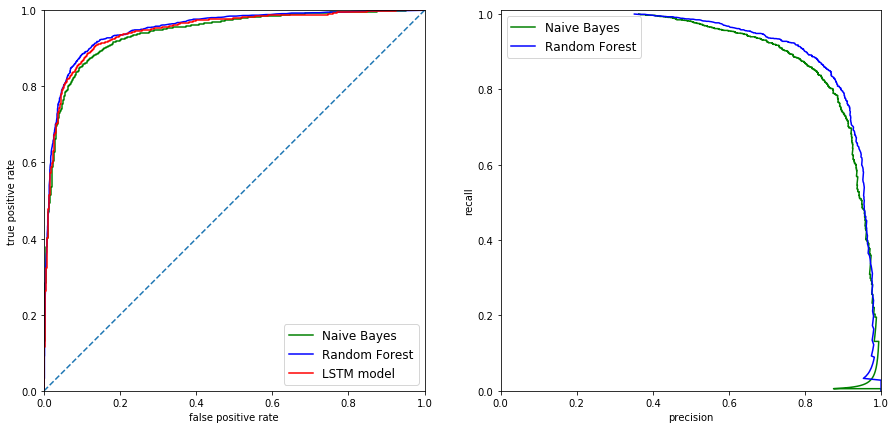

In [45]:
import matplotlib.pyplot as plt

fig, (ax,ax2) = plt.subplots(1,2,figsize=(15,7))
ax.plot(fpr_nb_ppl, tpr_nb_ppl,'green', label='Naive Bayes')
ax.plot(fpr_rf_ppl, tpr_rf_ppl,'blue', label='Random Forest')
ax.plot(fpr_lstm, tpr_lstm,'red', label='LSTM model')
ax.plot([0,1],[0,1],'--')
ax.legend(fontsize='large')
ax.set_xlabel('false positive rate'), ax.set_ylabel('true positive rate')
ax.set_xlim([0,1]), ax.set_ylim([0,1])

ax2.plot(prec_nb_ppl, rec_nb_ppl,'green', label='Naive Bayes')
ax2.plot(prec_rf_ppl, rec_rf_ppl,'blue', label='Random Forest')
ax2.legend(fontsize='large')
ax2.set_xlabel('precision'), ax2.set_ylabel('recall')
ax2.set_xlim([0,1]), ax2.set_ylim([0,1.01])

plt.show()

## Evaluation of most incorrect predictions

When we take a look at the titles of the most incorrectly predicted publications we see that many entries from the database (category=1) seem to be rather not of wide interest for the research group but just interesting for a specific project or idea of a single researcher. Also, there are of course spam entries that are actually of interest. These misclassifications and the unclear collection in the database are now the limiting factor for achieving a better training result. However, when using our models for the prediction of new publications we can assume that it will perform better than the test accuracy as the wrongly predicted test samples seem to be rather wrongly labeled.

In [47]:
predictions = pd.DataFrame(data={'title':X_test, 'category':y_test, 'prediction':y_pred_lstm, 'worst':abs(y_pred_lstm - y_test)})

In [49]:
pd.set_option('display.max_colwidth', -1)
predictions.sort_values('worst',ascending=False).head(20)

,title,category,prediction,worst
987,Determination of Surface Potential and Electrical Double-Layer Structure at the Aqueous Electrolyte-Nanoparticle Interface,1,0.001546,0.998454
3080,The Anomalous Hall Effect of Co$_{2}$FeAl$_{0.5}$Si$_{0.5}$/Pt Multilayers with Perpendicular Magnetic Anisotropy,1,0.001956,0.998044
3189,Current Induced Tilting of Domain Walls in High Velocity Motion along Perpendicularly Magnetized Micron-Sized Co/Ni/Co Racetracks,1,0.002006,0.997994
135,The classical and theoretical simulation for dominant radiated frequencies of plasma nanowire in presence of a long monopole antenna with long wavelength radiation,1,0.002033,0.997967
2183,Polarization-coupled polariton pairs in a birefringent microcavity,1,0.002291,0.997709
3107,An efficient measure of compactness for two-dimensional shapes and its application in regionalization problems,1,0.002339,0.997661
4083,Multigate transistors as the future of classical metal–oxide–semiconductor field-effect transistors,1,0.002385,0.997615
2894,Implementation of magnetic field assistance to current-induced perpendicular-magnetic-anisotropy racetrack memory,1,0.002623,0.997377
1129,"Nanoscience in the era of global science and global change—Cooperative, quantitative, and focused on benefit to humanity",1,0.002681,0.997319
824,Growth of Crystal Faces Enhanced by 3D Nuclei Deposition: A Monte Carlo Simulation,1,0.002747,0.997253


# Prediction for new publications

Finally, we can use our trained model now for the prediction of interesting articles that just got published. Most journals serve RSS feeds listing their new publications. Using the feedparser library I built a function to parse such a RSS feed into a pandas dataframe.

In [51]:
import feedparser

def parse_feed(address):
    feed_array = feedparser.parse(address)
    return feed_array

def parse_feed_list2df(feed_list):
    publications_list = []
    for feed_addr in feed_list:
        feed_parsed = parse_feed(feed_addr)
        for publication in feed_parsed.entries:
            publications_list.append((publication.title, publication.summary, publication.link))#publication.author
    feed_df = pd.DataFrame(publications_list, columns=['title', 'abstract', 'link']) #, 'author'
    return feed_df

In [52]:
addr_feed_new = ['http://feeds.feedburner.com/acs/nalefd']#'http://aip.scitation.org/action/showFeed?type=etoc&feed=rss&jc=apl']#'http://iopscience.iop.org/0957-4484/?rss=1'],
feed_new_df = parse_feed_list2df(addr_feed_new)

The titles of the new publications need to be converted to count-vectors using the same transformer as for the training procedure earlier. Then, I used this list of count-vectors for predictions of the degree of interest every new publication has for our scientific group.

In [55]:
X_feed_new = p.stem_documents(feed_new_df['title'])
y_feed_new = rf_pipeline.predict_proba(X_feed_new)

Let's see if the recommended publications sound interesting. By changing the threshold value for predictions, we can adjust the false positive and false negative rate so that we either do not miss any interesting publication but many uninteresting articles are recommended or we get less recommendations for uninteresting articles but may miss some interesting ones.

In [56]:
threshold_predict = 0.5
new_interesting_df = pd.DataFrame({'title':feed_new_df['title'].values, 'score':y_feed_new[:,1], 'link':feed_new_df['link'].values}).sort_values('score', ascending=False)

for index, entry in new_interesting_df.iterrows():
    if entry['score'] > threshold_predict:
        print(entry['score'], entry['title'])
        print(entry['link'])

0.9465 [ASAP] Near-Infrared Lasing at 1 µm from a Dilute-Nitride-Based Multishell Nanowire
http://feedproxy.google.com/~r/acs/nalefd/~3/AG6qxsYQraQ/acs.nanolett.8b04103
0.944 [ASAP] Vectorial Control of the Spin–Orbit Interaction in Suspended InAs Nanowires
http://feedproxy.google.com/~r/acs/nalefd/~3/NUp9MvhDs6A/acs.nanolett.8b02828
0.942 [ASAP] Ultraflexible Nanowire Array for Label- and Distortion-Free Cellular Force Tracking
http://feedproxy.google.com/~r/acs/nalefd/~3/zGZcZpnYVQI/acs.nanolett.8b02568
0.928 [ASAP] Preferential Positioning, Stability, and Segregation of Dopants in Hexagonal Si Nanowires
http://feedproxy.google.com/~r/acs/nalefd/~3/7e4fbMe1K2c/acs.nanolett.8b04083
0.9 [ASAP] Simulation of GaAs Nanowire Growth and Crystal Structure
http://feedproxy.google.com/~r/acs/nalefd/~3/G0Jsi1vEqbc/acs.nanolett.8b04637
0.588 [ASAP] Magnetic Force Sensing Using a Self-Assembled Nanowire
http://feedproxy.google.com/~r/acs/nalefd/~3/aQFPLawVHSc/acs.nanolett.8b04174
0.582 [ASAP] Ima

## Conclusion

I used the existing literature database in combination with requests from the DOI Crossref API to efficiently generate a dataset for classification of research article data. Fairly good accuracies were achieved with standard classifier models which can now be used in combination with RSS feeds for keeping up-to-date with the newest reasearch literature.

A major drawback was that the richer data from the articles' abstracts is difficult to access. Many entries in the database lack the information and so far there is no way to request it from the Crossref API. I believe that this data would push the accuracy of a classifier significantly. Also for these richer data more complex machine learning algorithms such as neural networks might bring an improvement in the classification.